In [ ]:


import os
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import numpy as np
from torchvision.models.resnet import ResNet, BasicBlock, Bottleneck
import torchinfo
from torchinfo import summary # similiar function to tensorflow/keras summary for torch
import torch.nn as nn
import torch.optim as optim
from tqdm.auto import tqdm
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns


In [1]:
#Import Kaggle dataset
import os
from pathlib import Path

os.environ["KAGGLE_KEY"] = os.getenv('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = os.getenv('KAGGLE_USERNAME')


In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("msambare/fer2013")

print("Path to dataset files:", path)


/home/mich02/Desktop/Disability_project_Vietnam/ai4li_VSL/ai4li_vsl_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 60.3M/60.3M [00:03<00:00, 19.3MB/s]

Extracting files...


Path to dataset files: /home/mich02/.cache/kagglehub/datasets/msambare/fer2013/versions/1


In [ ]:


train_root = "/home/mich02/Desktop/Disability_project_Vietnam/ai4li_VSL/data/train"
test_root  = "/home/mich02/Desktop/Disability_project_Vietnam/ai4li_VSL/data/test"

mean = np.array([0.485, 0.456, 0.406])
std  = np.array([0.229, 0.224, 0.225])

transform = transforms.Compose([
    transforms.Resize((256, 256)),  
    transforms.ToTensor(),  
    transforms.Normalize(mean=mean, std=std)
])

full_train_dataset = datasets.ImageFolder(root=train_root, transform=transform)
full_test_dataset  = datasets.ImageFolder(root=test_root,  transform=transform)

print("Classes:", full_train_dataset.classes)
print("Total images in train:", len(full_train_dataset))
print("Total images in test:", len(full_test_dataset))


total_images = len(full_train_dataset)
num_classes = len(full_train_dataset.classes) 

train_size = int(0.7 * total_images)   # 70%
val_size   = total_images - train_size # remaining 30%

# Set seed
g = torch.Generator().manual_seed(42)

train_data, val_data = random_split(
    full_train_dataset,
    [train_size, val_size],
    generator=g
)

print(f"Train set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")
print(f"Test set size: {len(full_test_dataset)}")


batch_size = 16

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_data,   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(full_test_dataset, batch_size=batch_size, shuffle=False)

images, labels = next(iter(train_loader))
print("Image tensor shape:", images.shape)
print("Label tensor shape:", labels.shape)


Classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Total images in train: 28709
Total images in test: 7178
Train set size: 20096
Validation set size: 8613
Test set size: 7178
Image tensor shape: torch.Size([16, 3, 256, 256])
Label tensor shape: torch.Size([16])


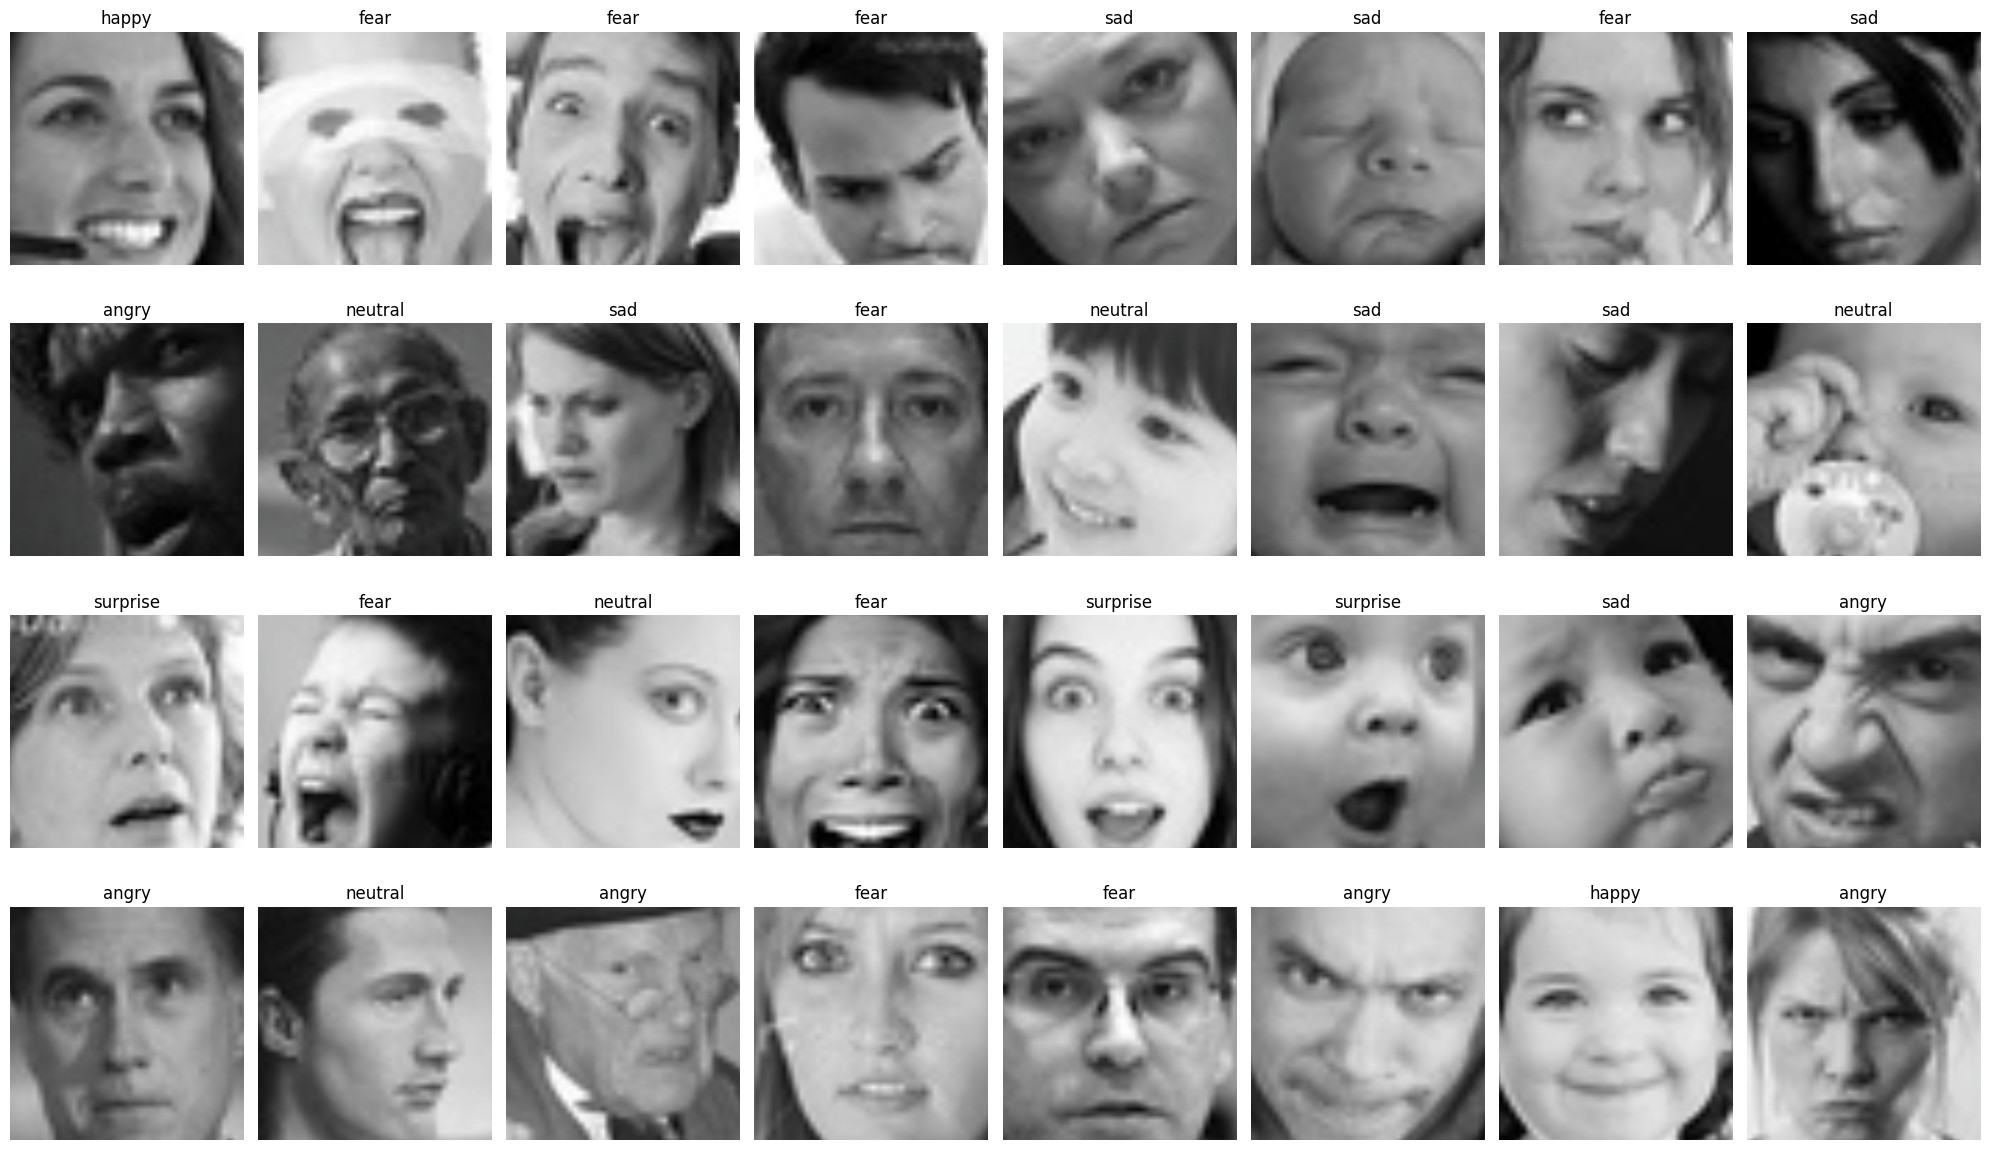

In [ ]:


# Function to unnormalize and convert tensor image to numpy for plotting
def imshow(img):
    img = img.numpy().transpose((1, 2, 0))  # (C,H,W) → (H,W,C)
    img = std * img + mean                  # unnormalize
    img = np.clip(img, 0, 1)                # keep values valid
    return img

class_names = full_train_dataset.classes

fig, axes = plt.subplots(4, 8, figsize=(20, 12))
axes = axes.flatten()

np.random.seed(42)
idx = np.random.choice(len(train_data), size=32, replace=False)

for i, ix in enumerate(idx):
    img, label = train_data[ix]

    axes[i].axis('off')
    axes[i].imshow(imshow(img))
    axes[i].set_title(class_names[label], fontsize=12, color='black')

plt.tight_layout()
plt.show()


In [ ]:


class MyResNet (ResNet):
    def __init__(self, 
                 block = BasicBlock,
                 layers = [2, 2, 2, 2],
                 num_classes = num_classes):
        super(MyResNet, self).__init__(block,
                                       layers,
                                       num_classes = num_classes)
        self.conv1 = nn.Conv2d(3, 64, kernel_size = 7, stride = 1, padding = 3, bias = False)
        
        '''
        you can modify the layers in this initialization of ResNet if you like
        '''
        
#Choose 1
resnet18 = {
    'block': BasicBlock,
    'layers': [2, 2, 2, 2]
}

resnet34 = {
    'block': BasicBlock,
    'layers': [3, 4, 6, 3]
}

resnet50 = {
    'block' : Bottleneck,
    'layers' : [3, 4, 6, 3]
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#model = MyResNet(**resnet50).to(device)


model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
in_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(p=0.3),
    nn.Linear(in_features, num_classes)
)
model = model.to(device)


In [ ]:
#%pip install torchinfo -q


In [ ]:



summary(model, input_size = (batch_size, 3, 28, 28), device = "cpu") # (color_channel, 28, 28)

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [16, 7]                   --
├─Conv2d: 1-1                            [16, 64, 14, 14]          9,408
├─BatchNorm2d: 1-2                       [16, 64, 14, 14]          128
├─ReLU: 1-3                              [16, 64, 14, 14]          --
├─MaxPool2d: 1-4                         [16, 64, 7, 7]            --
├─Sequential: 1-5                        [16, 256, 7, 7]           --
│    └─Bottleneck: 2-1                   [16, 256, 7, 7]           --
│    │    └─Conv2d: 3-1                  [16, 64, 7, 7]            4,096
│    │    └─BatchNorm2d: 3-2             [16, 64, 7, 7]            128
│    │    └─ReLU: 3-3                    [16, 64, 7, 7]            --
│    │    └─Conv2d: 3-4                  [16, 64, 7, 7]            36,864
│    │    └─BatchNorm2d: 3-5             [16, 64, 7, 7]            128
│    │    └─ReLU: 3-6                    [16, 64, 7, 7]            --
│ 

In [ ]:
# Define your model, optimizer, and loss function
learning_rate = 3e-4
loss_func = nn.CrossEntropyLoss(label_smoothing = 0.1)

# Optimizer only over trainable params
learning_rate = 3e-4
optimizer = optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=learning_rate,
    weight_decay=1e-4, #L2 Regularization
)

# Scheduler (same as before)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.1, patience=3
)

epochs = 100
acc_last_epoch = 0.0
acc_max = 0.0
tolerance = 10  # Number of epochs to wait for improvement before stopping
best_val_loss = float('inf')  # Set the initial best validation loss to infinity
early_stop_counter = 0  # Initialize the early stopping counter


# Lists to store metrics for visualization
train_losses = []
val_losses = []
val_accuracies = []

In [56]:
#Move to GPU
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:


# ---------------------------------
# 2) Training loop (backbone frozen)
# ---------------------------------
for epoch in range(epochs):
    model.train()
    train_loss = 0.0

    # (Optional) print how many params are trainable
    if epoch == 0:
        total_params = sum(p.numel() for p in model.parameters())
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f"Trainable params: {trainable_params}/{total_params}")

    with tqdm(total=len(train_loader),
              desc=f'Epoch {epoch+1}/{epochs}',
              unit='batch') as pbar:
        for x, targets in train_loader:
            x, targets = x.to(device), targets.to(device)

            outputs = model(x)
            loss = loss_func(outputs, targets)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            pbar.set_postfix(loss=loss.item())
            pbar.update()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # ----- Validation -----
    model.eval()
    val_loss = 0.0
    val_acc = 0.0

    with torch.no_grad():
        with tqdm(total=len(val_loader),
                  desc=f'Validation {epoch+1}/{epochs}',
                  unit='batch') as pbar_val:
            for x_v, y_v in val_loader:
                x_v, y_v = x_v.to(device), y_v.to(device)

                logits = model(x_v)
                preds = logits.argmax(dim=-1)

                val_loss += loss_func(logits, y_v).item()
                val_acc += (preds == y_v).float().mean().item()

                pbar_val.update()

    val_loss /= len(val_loader)
    val_acc  /= len(val_loader)

    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f'Epoch {epoch+1}/{epochs} - '
          f'Train Loss: {train_loss:.4f}, '
          f'Val Loss: {val_loss:.4f}, '
          f'Val Acc: {val_acc:.4f}')

    # LR scheduler step (on val loss)
    scheduler.step(val_loss)

    # ----- Early stopping -----
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
        print("Validation loss improved — resetting early stopping.")
    else:
        early_stop_counter += 1
        print(f"No improvement in val loss for {early_stop_counter} epochs.")

    if early_stop_counter >= tolerance:
        print(f"🔥 Early stopping triggered at epoch {epoch+1}")
        break


Trainable params: 23522375/23522375


Validation 1/100: 100%|██████████| 539/539 [00:12<00:00, 44.80batch/s]


Epoch 1/100 - Train Loss: 1.4535, Val Loss: 1.3622, Val Acc: 0.5478
Validation loss improved — resetting early stopping.


Validation 2/100: 100%|██████████| 539/539 [00:12<00:00, 44.34batch/s]


Epoch 2/100 - Train Loss: 1.3096, Val Loss: 1.3149, Val Acc: 0.5678
Validation loss improved — resetting early stopping.


Validation 3/100: 100%|██████████| 539/539 [00:12<00:00, 43.35batch/s]


Epoch 3/100 - Train Loss: 1.2281, Val Loss: 1.2817, Val Acc: 0.5994
Validation loss improved — resetting early stopping.


Validation 4/100: 100%|██████████| 539/539 [00:12<00:00, 43.93batch/s]


Epoch 4/100 - Train Loss: 1.1510, Val Loss: 1.2673, Val Acc: 0.6078
Validation loss improved — resetting early stopping.


Validation 5/100: 100%|██████████| 539/539 [00:12<00:00, 43.10batch/s]


Epoch 5/100 - Train Loss: 1.0688, Val Loss: 1.2772, Val Acc: 0.6161
No improvement in val loss for 1 epochs.


Validation 6/100: 100%|██████████| 539/539 [00:12<00:00, 44.80batch/s]


Epoch 6/100 - Train Loss: 0.9577, Val Loss: 1.3401, Val Acc: 0.6074
No improvement in val loss for 2 epochs.


Validation 7/100: 100%|██████████| 539/539 [00:11<00:00, 45.03batch/s]


Epoch 7/100 - Train Loss: 0.8265, Val Loss: 1.3906, Val Acc: 0.5994
No improvement in val loss for 3 epochs.


Validation 8/100: 100%|██████████| 539/539 [00:12<00:00, 44.20batch/s]


Epoch 8/100 - Train Loss: 0.7102, Val Loss: 1.4026, Val Acc: 0.5950
No improvement in val loss for 4 epochs.


Validation 9/100: 100%|██████████| 539/539 [00:12<00:00, 44.29batch/s]


Epoch 9/100 - Train Loss: 0.5612, Val Loss: 1.3065, Val Acc: 0.6361
No improvement in val loss for 5 epochs.


Validation 10/100: 100%|██████████| 539/539 [00:12<00:00, 44.27batch/s]


Epoch 10/100 - Train Loss: 0.5133, Val Loss: 1.3178, Val Acc: 0.6391
No improvement in val loss for 6 epochs.


Validation 11/100: 100%|██████████| 539/539 [00:12<00:00, 43.36batch/s]


Epoch 11/100 - Train Loss: 0.4956, Val Loss: 1.3079, Val Acc: 0.6375
No improvement in val loss for 7 epochs.


Validation 12/100: 100%|██████████| 539/539 [00:12<00:00, 44.44batch/s]


Epoch 12/100 - Train Loss: 0.4843, Val Loss: 1.3091, Val Acc: 0.6386
No improvement in val loss for 8 epochs.


Validation 13/100: 100%|██████████| 539/539 [00:12<00:00, 44.58batch/s]


Epoch 13/100 - Train Loss: 0.4762, Val Loss: 1.3051, Val Acc: 0.6365
No improvement in val loss for 9 epochs.


Validation 14/100: 100%|██████████| 539/539 [00:12<00:00, 44.60batch/s]

Epoch 14/100 - Train Loss: 0.4740, Val Loss: 1.2955, Val Acc: 0.6374
No improvement in val loss for 10 epochs.
🔥 Early stopping triggered at epoch 14


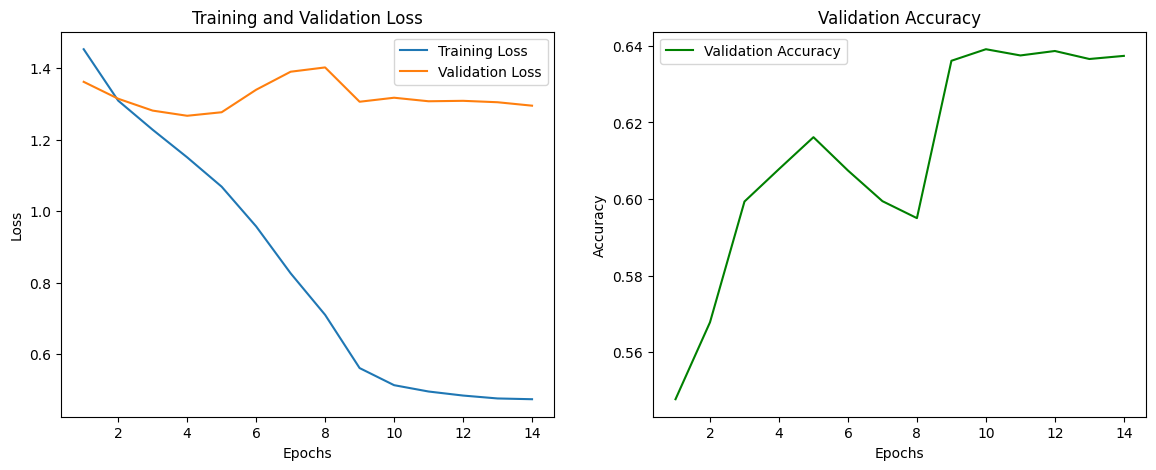

In [59]:
# Visualization

# Create subplots for loss and accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot training and validation loss
ax1.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
ax1.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot validation accuracy
ax2.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy', color='green')
ax2.set_title('Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

# Display the plots
plt.show()


🔥 Test Accuracy: 0.6365

📊 Classification Report:

              precision    recall  f1-score   support

       angry       0.56      0.56      0.56       958
     disgust       0.82      0.37      0.51       111
        fear       0.49      0.41      0.45      1024
       happy       0.85      0.85      0.85      1774
     neutral       0.57      0.58      0.57      1233
         sad       0.49      0.56      0.52      1247
    surprise       0.76      0.78      0.77       831

    accuracy                           0.64      7178
   macro avg       0.65      0.59      0.60      7178
weighted avg       0.64      0.64      0.64      7178



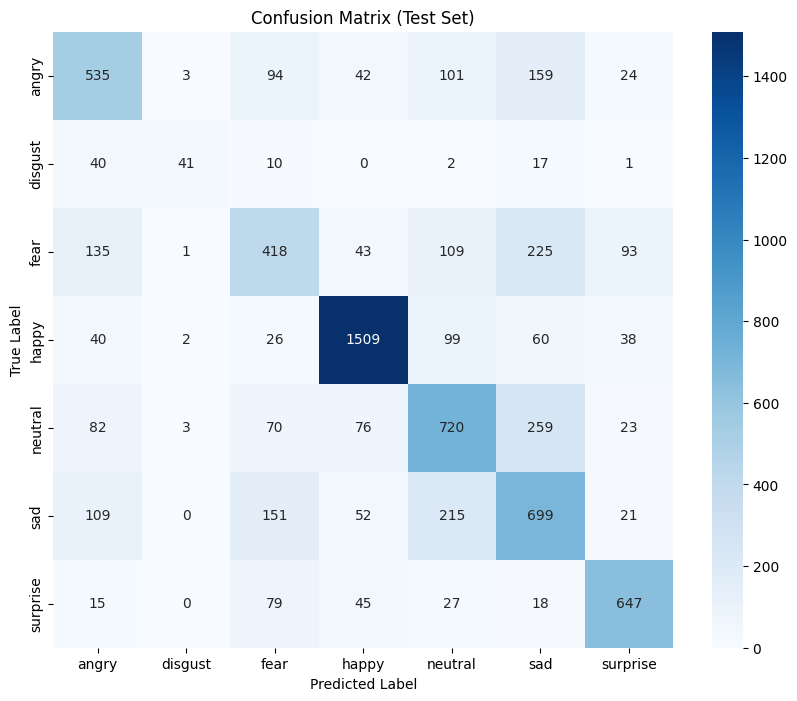

In [ ]:



model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs  = inputs.to(device)
        labels  = labels.to(device)

        outputs = model(inputs)
        preds   = outputs.argmax(dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


test_acc = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {test_acc:.4f}")


class_names = full_train_dataset.classes  # same order as ImageFolder

print("\nClassification Report:\n")
print(classification_report(all_labels, all_preds, target_names=class_names))


cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Test Set)")
plt.show()


In [63]:
from ptflops import get_model_complexity_info
import torch
import torchvision.models as models

model = models.resnet50(weights=None)   # flops doesn't depend on weights

with torch.cuda.device(0):
    macs, params = get_model_complexity_info(
        model, (3, 224, 224), as_strings=True,
        print_per_layer_stat=False, verbose=False
    )

print("MACs:", macs)
print("Params:", params)


MACs: 4.13 GMac
Params: 25.56 M
